영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow as tf
import pandas as pd
import re

## Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

In [2]:
file_path = '../transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(file_path, header=0)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
data.shape

(11823, 3)

In [4]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

## Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [5]:
Q = []
for sentence in data.Q:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    Q.append(sentence)

In [6]:
A = []
for sentence in data.A:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    A.append(sentence)

In [7]:
print(Q[:5])
print(A[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### 3.1 단어장 만들기

In [8]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q + A, target_vocab_size=2**13)

시작 토큰과 종료 토큰에 고유한 정수 부여

In [9]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]


시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정

In [10]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8180


### 3.2 각 단어를 고유 정수로 인코딩 & 패딩

각 질문과 답변 샘플 한개를 인코딩, 디코딩 해보기

In [11]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
tok_question = tokenizer.encode(Q[21])
tok_answer = tokenizer.encode(A[21])
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(Q[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(A[21])))

정수 인코딩 후의 21번째 질문 샘플: [5766, 611, 2495, 4167]
정수 인코딩 후의 21번째 답변 샘플: [2359, 7516, 7, 6279, 97, 1]


In [12]:
print('디코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.decode(tok_question)))
print('디코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.decode(tok_answer)))

디코딩 후의 21번째 질문 샘플: 가스비 장난 아님
디코딩 후의 21번째 답변 샘플: 다음 달에는 더 절약해봐요 .


인코딩한 질문 샘플은 정수가 4개인데 원문의 어절은 3개임. 같은 맥락으로 답변 샘플도 인코딩된 문장은 정수가 6개인 반면, 원문의 어절은 마침표를 포함해서 5개임. 각 정수가 어떤 서브워드를 mapping하고 있는지 출력해보기

In [13]:
for ts in tok_question:
    print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
2495 ----> 장난 
4167 ----> 아님


In [14]:
for ts in tok_answer:
    print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

2359 ----> 다음 
7516 ----> 달에는 
7 ----> 더 
6279 ----> 절약해
97 ----> 봐요
1 ---->  .


가스비가 [가스, 비]로, 절약해봐요는 [절약해, 봐요]로 나뉜상태로 정수 인코딩이 되어있음을 알 수 있음.

질문 최소 길이 : 1
질문 최대 길이 : 16
질문 평균 길이 : 3.9402858834475176
답변 최소 길이 : 1
답변 최대 길이 : 24
답변 평균 길이 : 4.71589275141673


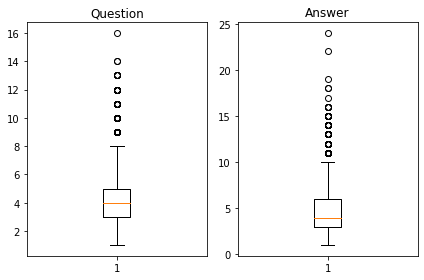

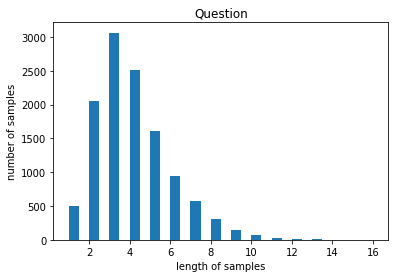

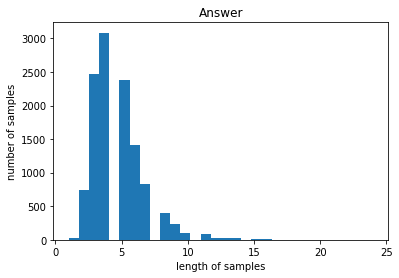

In [15]:
import matplotlib.pyplot as plt
import numpy as np

Q_len = [len(s.split()) for s in Q]
A_len = [len(s.split()) for s in A]

print('질문 최소 길이 : {}'.format(np.min(Q_len)))
print('질문 최대 길이 : {}'.format(np.max(Q_len)))
print('질문 평균 길이 : {}'.format(np.mean(Q_len)))
print('답변 최소 길이 : {}'.format(np.min(A_len)))
print('답변 최대 길이 : {}'.format(np.max(A_len)))
print('답변 평균 길이 : {}'.format(np.mean(A_len)))

plt.subplot(1,2,1)
plt.boxplot(Q_len)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(A_len)
plt.title('Answer')
plt.tight_layout()
plt.show()

plt.title('Question')
plt.hist(Q_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answer')
plt.hist(A_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

질문과 답변의 최대 길이는 16, 24로 길지 않음. 질문과 답변의 최대 길이는 SOS와 EOS를 고려하여 26을 기준으로 패딩 진행

In [16]:
MAX_LENGTH = 26

def tokenize_and_padding(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
        
    # 최대 길이 26로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
        
    return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_padding(Q, A)

In [18]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 26)
답변 데이터의 크기(shape) : (11823, 26)


In [19]:
questions[5]

array([8178, 8005, 7990, 2192,  919,   78,  821, 8179,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [20]:
answers[5]

array([8178,   69, 2064,  456,    5,  137, 2188,   17,    1, 8179,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

## Step 4. 모델 구성하기
---

Postional Encoding 구현

In [21]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2*(i//2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                    i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                    d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]        

스케일드 닷 프로덕트 어텐션 구현

In [22]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

  # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

멀티헤드어텐션 구현

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
             'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

교사 강요를 위해 디코더 입력은 END_TOKEN 제외하고 디코더 출력은 START_TOKEN 제거

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices(({'inputs': questions,
                                              'dec_inputs': answers[:, :-1]},
                                             {'outputs':answers[:, 1:]}))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

패딩 마스킹 구현

In [25]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

Lookahead mask 구현

In [26]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

하나의 인코더 층 구현(self attention과 feed forward 층으로 이루어짐)

In [27]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask})

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 층을 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 인코더 층을 원하는 만큼 쌓아 트랜스포머의 인코더 완성

In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i))([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

하나의 디코더 층 구현(3개의 서브 층으로 구성됨)

In [29]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input( shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, 
                                    num_heads, 
                                    name="attention_1")(inputs={'query': inputs,
                                                                'key': inputs,
                                                                'value': inputs,
                                                                'mask': look_ahead_mask})

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={'query': attention1,
                                                                                    'key': enc_outputs,
                                                                                    'value': enc_outputs,
                                                                                    'mask': padding_mask})

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs, name=name)

인코더 층과 마찬가지로 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더 완성

In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name='decoder_layer_{}'.format(i))(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,name=name)

트랜스포머 생성

In [31]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                             output_shape=(1, 1, None),
                                             name='enc_padding_mask')(inputs)
    # 디코더에서 미래의 토큰을 마스크 하기 위해 사용
    # 내부적으로 패딩 마스크도 포함되어 있음
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                            output_shape=(1, None, None),
                                            name='look_ahead_mask')(dec_inputs)
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                             output_shape=(1, 1, None),
                                             name='dec_padding_mask')(inputs)
    
    # Encoder
    enc_outputs = encoder(vocab_size=vocab_size, 
                          num_layers=num_layers, 
                          units=units, 
                          d_model=d_model, 
                          num_heads=num_heads, 
                          dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    # Decoder
    dec_outputs = decoder(vocab_size=vocab_size, 
                          num_layers=num_layers, 
                          units=units, 
                          d_model=d_model, 
                          num_heads=num_heads, 
                          dropout=dropout)(inputs=[dec_inputs, enc_outputs,
                                                  look_ahead_mask,
                                                  dec_padding_mask])
    
    # 완전 연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256  # 인코더와 디코어 내부의 입, 출력 차원
NUM_LAYERS = 2 # 인코더와 디코더 층의 개수
NUM_HEADS= 8  # 멀티헤드 어텐션의 헤드 수
UNITS = 512    # feed forward 신경망의 은닉층 크기
DROPOUT = 0.1

model = transformer(vocab_size = VOCAB_SIZE,
                   num_layers = NUM_LAYERS,
                   units = UNITS,
                   d_model = D_MODEL,
                   num_heads = NUM_HEADS,
                   dropout = DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실 함수 정의(레이블인 시퀀스에 패딩이 되어있으므로 loss를 계산할 때 패딩 마스크를 적용해야 함)

In [33]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

커스텀 학습률(Learning rate) 설계

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
 
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [35]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 학습

In [36]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 27s 43ms/step - loss: 2.2660 - accuracy: 0.0457
Epoch 2/50
185/185 [==============================] - 8s 43ms/step - loss: 1.8354 - accuracy: 0.0773
Epoch 3/50
185/185 [==============================] - 8s 42ms/step - loss: 1.5675 - accuracy: 0.0792
Epoch 4/50
185/185 [==============================] - 8s 43ms/step - loss: 1.4492 - accuracy: 0.0849
Epoch 5/50
185/185 [==============================] - 8s 43ms/step - loss: 1.3572 - accuracy: 0.0901
Epoch 6/50
185/185 [==============================] - 8s 43ms/step - loss: 1.2649 - accuracy: 0.0966
Epoch 7/50
185/185 [==============================] - 8s 43ms/step - loss: 1.1641 - accuracy: 0.1055
Epoch 8/50
185/185 [==============================] - 8s 43ms/step - loss: 1.0518 - accuracy: 0.1170
Epoch 9/50
185/185 [==============================] - 8s 43ms/step - loss: 0.9277 - accuracy: 0.1307
Epoch 10/50
185/185 [==============================] - 8s 43ms/step - loss: 0.7987 - accur

## Step 5. 모델 평가하기
---

In [40]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [41]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
              break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [42]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [43]:
sentence_generation("너무 졸려")

입력 : 너무 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요 .


'낮잠을 잠깐 자도 괜찮아요 .'

In [47]:
sentence_generation("저녁에 뭐 먹지?")

입력 : 저녁에 뭐 먹지?
출력 : 한 번만 더 연락해보는 건 어떨까요 .


'한 번만 더 연락해보는 건 어떨까요 .'

In [48]:
sentence_generation("딥러닝은 참 어려워")

입력 : 딥러닝은 참 어려워
출력 : 구구릿빛 피부 좋죠 !


'구구릿빛 피부 좋죠 !'

In [49]:
sentence_generation("배고파")

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

In [52]:
sentence_generation("저녁 추천해줘")

입력 : 저녁 추천해줘
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [54]:
sentence_generation("무슨 노래 좋아해?")

입력 : 무슨 노래 좋아해?
출력 : 저도 부러워요 .


'저도 부러워요 .'

In [55]:
sentence_generation("대학원 진학에 대해서 어떻게 생각해?")

입력 : 대학원 진학에 대해서 어떻게 생각해?
출력 : 꿈에 도전하는 건 좋은 거라고 들었어요 .


'꿈에 도전하는 건 좋은 거라고 들었어요 .'

## 회고 및 정리
- 전체적인 과제 실행은 어려움이 없었으나, 트랜스포머 모델 구현에 사용되는 각 층 및 component에 대한 개념이 생소하고 복잡해서 성능 개선보다 이해하고 정리하는데에 초점을 두었다. 


1. 교사 강요(Teacher Forcing)
    - 정의 : __테스트 과정__ 에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 훈련 기법. __훈련시__ 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용함.
    - 교사 강요를 하지 않으면 잘못된 예측이 다음 시점의 입력으로 들어가기 때문에 연쇄적으로 예측 정확도에 영향을 미침.
    - 즉, 훈련 과정에서 훈련 속도가 느려지고 성능 개선이 어려움.
    - __트랜스포머 모델의 디코더에 교사 강요가 적용됨__
    
    
2. tf.data.Dataset API (훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API)
    - __Prefetching(가져오기)__
    - 모델이 s 스텝 훈련을 실행하는 동안 입력 파이프라인은 s+1 스텝의 데이터를 읽어서 데이터가 학습되는 시간과 데이터가 생성되는 시간 사이의 간극을 최소화함.
 > dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
 
 
3. Padding masking과 look-ahead masking
    - __Padding masking__
    - padding으로 채워진 무의미한 단어를 마스크로 가려서 실제 연산에 방해가 되지 않도록 하는 기법.
    - 자연어 처리에서 padding은 문장 길이를 동일하게 해주는 과정해서 특정 길이보다 짧은 문장을 padding으로 채움 (pad_sequences)
    - __look-ahead masking__
    - RNN은 각 step마다 단어가 순서대로 입력되지만, 트랜스포머는 전체 문장이 문장 행렬로 한꺼번에 들어가기 때문에 어순과 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있게됨. 
    -다음에 나올 단어를 참고하지 않고 이전 단어들로부터 다음 단어를 예측하는 훈련을 할 수 있도록 Query 단어 뒤에 나오는 key 단어에 대해 마스킹을 진행함
    
    
4. 트랜스포머의 인코더 층 (embedding + positional-encoding + Self-attention + feed forward Neural Network)
    - __padding mask 사용__
    - __positional-encoding__
    - embedding layer에 positional encoding 레이어를 더해서 사용.
    - positional encoding은 문장 행렬이 입력으로 들어가는 트랜스포머 특성상 단어 위치에따른 정보를 주기 위함.
    - __Self-attention__
    - 인코더의 입력으로 들어간 문장 내 단어들 사이의 유사도를 구함.
    
    
5. 트랜스포머의 디코더 층 (embedding + positional-encoding + self attention + encoder-decoder attention + feed forward Neural Network)
    - __padding mask , look ahead mask 사용__
    - __Multihead attention(self attention)__
    - 이미 생성된 앞 단어들과의 유사도를 구함.
    - __encoder-decoder attention__
    - 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구함.
    - Query(시점 t에서 생성된 단어)는 __디코더의 벡터__ 인 반면, Key와 Value는 __인코더의 벡터__ 임.
    - 위 과정에 의해 인코더가 디코더에 정보를 전달 할 수 있음.
    - __주의__
    - 트랜스포머 모델에 사용되는 모든 어텐션 레이어는 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행함.
    
6. 손실함수
    - 문장 시퀀스에 패딩이 되어있는 경우, loss를 계산할 때도 패딩 마스크를 적용해야 함.

7. 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
    - 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 기법
    - tf.keras.optimizers.schedules.LearningRateSchedule 클래스를 상속받아 사용 가능함.